In [37]:
from multiprocessing import Pool,sharedctypes
from functools import partial
from contextlib import closing
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import h5py as h5
import os
import sys
import skymapper as skm
import matplotlib.cm as cm
import matplotlib

In [38]:
def getHealpixCoords(pixels, nside, nest=False):
    # convert healpix cell indices to center ra/dec
    import healpy as hp
    theta, phi = hp.pix2ang(nside, pixels, nest=nest)
    return phi * 180. / np.pi, 90 - theta * 180. / np.pi


def log_skm_plot(mapa, mask, sep=15, ra = None, dec = None, richness = None, title = None, add_rmp = True, small_scale = False, cb_label = 'number density [n_gal/arcmin$^2$]', x_size = 6, y_size = 6, vmin = -0.01, vmax = 0.01):
    cmap = cm.RdYlBu_r
    fig = plt.figure(figsize=(x_size,y_size))
    ax = fig.add_subplot(111, aspect='equal')
       
    reticule = sep
    nside = hp.pixelfunc.npix2nside(len(mapa))
    pixels = np.array(range(len(mapa)))
    pixels = pixels[~mask]
    print(pixels)
    ra_, dec_ = getHealpixCoords(pixels, nside)

    # setup map: define AEA map optimal for given RA/Dec
    #proj = skm.createConicMap(ax, ra_, dec_, proj_class=skm.AlbersEqualAreaProjection)
    crit = skm.stdDistortion
    proj = skm.Albers.optimize(ra_, dec_, crit=crit)
    # add lines and labels for meridians/parallels (separation 5 deg)
    
    parallels = np.arange(0. ,360., reticule)
    meridians = np.arange(-90., 90., reticule)
    # convert to map coordinates and plot a marker for each point
    x,y = proj(ra_, dec_)
    marker = 's'
    #markersize = skm.getMarkerSizeToFill(fig, ax, x, y)
    #s=markersize,
    sc = ax.scatter(x,y, c=mapa[pixels], edgecolors='None', marker=marker, s=2,  cmap=cmap, vmin=vmin, vmax=vmax, rasterized=True, zorder=1,
                norm=matplotlib.colors.LogNorm())
    xlabels=ax.get_xticks()
    ylabels=ax.get_yticks()
    print(xlabels,ylabels)
    #ax.set_xticklabels(ra_,dec_)
    #ax.set_xticklabels(map(str, ax.get_xticks()/5.0))
    #labels=getHealpixCoords(labels, nside)
    #print(labels)

    # overplot with another data set
    # here clusters [not implemented]
    if add_rmp:
        x,y = proj(ra, dec)
        ax.scatter(x,y, c='None', edgecolors='k', linewidths=1, s=richness, marker='o', zorder=3)
    if title:
        plt.title(title)

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    
    cax = divider.append_axes("right", size="2%", pad=0.3)
    cb = fig.colorbar(sc, cax=cax )
    if cb_label != None:
        cb.set_label(cb_label)
    ticks = np.linspace(vmin, vmax, 5)
    cb.set_ticks(ticks)
    if small_scale:
        cb.set_ticklabels([('%.1f' % (t))   for t in ticks])       
    else:
        cb.set_ticklabels([('%.1f' % (t))   for t in ticks])
    cb.solids.set_edgecolor("face")
    fig.show()

    
def skm_plot(mapa, mask, sep=15, ra = None, dec = None, richness = None, title = None, add_rmp = True, small_scale = False, cb_label = 'number density [n_gal/arcmin$^2$]', x_size = 6, y_size = 6, vmin = -0.01, vmax = 0.01):
    cmap = cm.RdYlBu_r
    fig = plt.figure(figsize=(x_size,y_size))
    ax = fig.add_subplot(111, aspect='equal')
       
    reticule = sep
    nside = hp.pixelfunc.npix2nside(len(mapa))
    pixels = np.array(range(len(mapa)))
    pixels = pixels[~mask]
    ra_, dec_ = getHealpixCoords(pixels, nside)

    # setup map: define AEA map optimal for given RA/Dec
    crit = skm.stdDistortion
    proj = skm.Albers.optimize(ra_, dec_, crit=crit)
    # add lines and labels for meridians/parallels (separation 5 deg)
    
    parallels = np.arange(0. ,360., reticule)
    meridians = np.arange(-90., 90., reticule)
    # convert to map coordinates and plot a marker for each point
    x,y = proj(ra_, dec_)
    marker = 's'

    sc = ax.scatter(x,y, c=mapa[pixels], edgecolors='None', marker=marker, s=2,  cmap=cmap, vmin=vmin, vmax=vmax, rasterized=True, zorder=1)

    # overplot with another data set
    if add_rmp:
        x,y = proj(ra, dec)
        ax.scatter(x,y, c='None', edgecolors='k', linewidths=1, s=richness, marker='o', zorder=3)
    if title:
        plt.title(title)

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    
    cax = divider.append_axes("right", size="2%", pad=0.3)
    cb = fig.colorbar(sc, cax=cax )
    if cb_label != None:
        cb.set_label(cb_label)
    ticks = np.linspace(vmin, vmax, 5)
    cb.set_ticks(ticks)
    if small_scale:
        cb.set_ticklabels([('%.1f' % (t))   for t in ticks])       
    else:
        cb.set_ticklabels([('%.1f' % (t))   for t in ticks])
    cb.solids.set_edgecolor("face")
    fig.show()

    

In [39]:
bins = ['all']
nside = 1024
def convert_to_pix_coord(ra, dec, nside=1024):
    """
    Converts RA,DEC to hpix coordinates
    """
    theta = (90.0 - dec) * np.pi / 180.
    phi = ra * np.pi / 180.
    pix = hp.ang2pix(nside, theta, phi, nest=False)
    return pix
print 'done' 

done


In [40]:

# read File *******
File_data = "/global/cscratch1/sd/troxel/cats_des_y3/Y3_mastercat_03_16_20_highsnr.h5"
#"/project/projectdirs/des/www/y3_cats/Y3_mastercat_12_3_19.h5"
master = h5.File(File_data,'r')

master['catalog']['metacal']['unsheared'].keys()

[u'R11',
 u'R12',
 u'R21',
 u'R22',
 u'T',
 u'T_err',
 u'coadd_object_id',
 u'covmat_0_1',
 u'covmat_1_1',
 u'covmat_2_2',
 u'dec',
 u'e_1',
 u'e_2',
 u'flags',
 u'flux_err_i',
 u'flux_err_r',
 u'flux_err_z',
 u'flux_i',
 u'flux_r',
 u'flux_z',
 u'mask_frac',
 u'mcal_psf_T',
 u'mcal_psf_e1',
 u'mcal_psf_e2',
 u'nimage_tot_i',
 u'nimage_tot_r',
 u'nimage_tot_z',
 u'nimage_use_i',
 u'nimage_use_r',
 u'nimage_use_z',
 u'psf_T',
 u'psf_e1',
 u'psf_e2',
 u'ra',
 u'size_ratio',
 u'snr',
 u'weight']

In [41]:
select_metacal  = np.array(master['index']['select_shape']) # gold + mcal
select_all  = np.array(master['index']['select'])  # photo + gold + mcal
select_metacal_1p  = np.array(master['index']['select_shape_1p'])
select_metacal_1m  = np.array(master['index']['select_shape_1m'])
select_metacal_2p  = np.array(master['index']['select_shape_2p'])
select_metacal_2m  = np.array(master['index']['select_shape_2m'])

ra_master = np.array(master['catalog']['metacal']['unsheared']['ra'])
dec_master =  np.array(master['catalog']['metacal']['unsheared']['dec'])
mmm = dict()
cat = dict()
snr = np.array(master['catalog']['metacal']['unsheared']['snr']) #[select_all]
e1 = np.array(master['catalog']['metacal']['unsheared']['e_1'])#[select_all]
e2 = np.array(master['catalog']['metacal']['unsheared']['e_2'])#[select_all]
e1p = np.array(master['catalog']['metacal']['sheared_1p']['e_1'])#[select_metacal]
e1m = np.array(master['catalog']['metacal']['sheared_1m']['e_1'])#[select_metacal]
e2p = np.array(master['catalog']['metacal']['sheared_2p']['e_2'])#[select_metacal]
e2m = np.array(master['catalog']['metacal']['sheared_2m']['e_2'])#[select_metacal]
w = np.array(master['catalog']['metacal']['unsheared']['weight'])

# compute response: 
dgamma = 2. * 0.01
R11_1 = (np.mean(e1p) - np.mean(e1m) + np.mean(
e1[select_metacal_1p]) - np.mean(
e1[select_metacal_1m]))/ dgamma
R22_1 = (np.mean(e2p) - np.mean(e2m) + np.mean(
e2[select_metacal_2p]) - np.mean(
e2[select_metacal_2m])) / dgamma
print R11_1
print R22_1


0.37501983100677166
0.3767838006539138


101184040
5.905197632838893
optimizing parameters of Albers to minimize stdDistortion
best objective 0.046034 at Albers(25.31394925294536,-35.86924773198294,-57.27823104418549,-11.346250239135758)


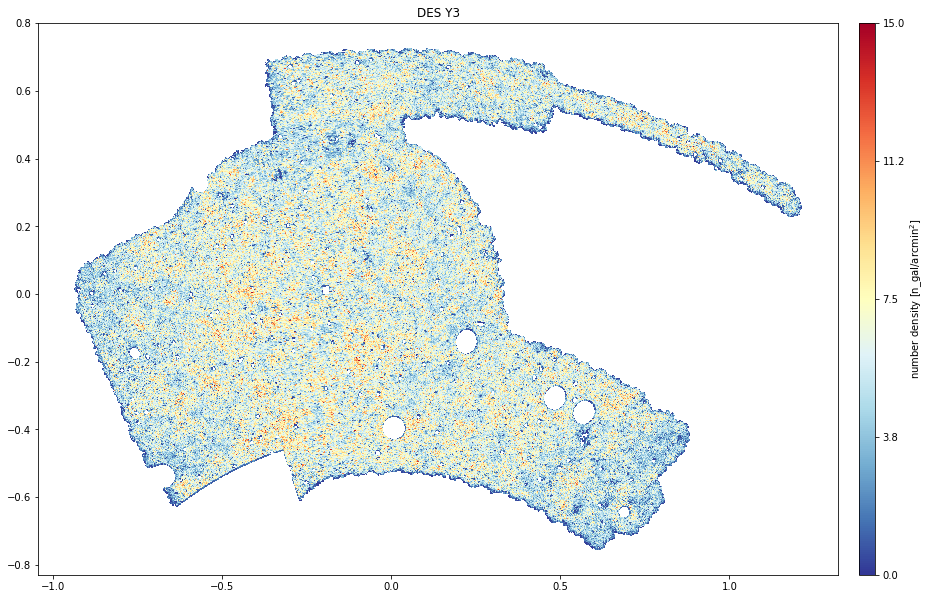

In [42]:
#neff map - needs weighting implemented 

desy3_map = np.zeros(hp.nside2npix(nside))
pix1 = convert_to_pix_coord(ra_master[select_all],dec_master[select_all], nside=nside)
print len(ra_master[select_all])
unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)
desy3_map[unique_pix1] += np.bincount(idx_rep1, weights=np.ones(len(pix1)))
mas_desy3 = desy3_map!=0.
res = desy3_map/(hp.pixelfunc.nside2pixarea(nside,degrees=True)*(60*60)) #/R_ave
print np.mean(res[mas_desy3])
skm_plot(res, ~mas_desy3 , sep=15 , title = 'DES Y3',add_rmp=False, ra = [], dec = [], richness = [], x_size = 15, y_size = 15, vmin = 0, vmax = 15,small_scale='True')
plt.savefig('number_density.pdf')

32.81423154016958
7.5306713154813485
75.80910140671868
32.66207619459448
[ 5695852  5695853  5695854 ... 12117619 12117620 12117621]
optimizing parameters of Albers to minimize stdDistortion
best objective 0.046034 at Albers(25.31394925294536,-35.86924773198294,-57.27823104418549,-11.346250239135758)
(array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))


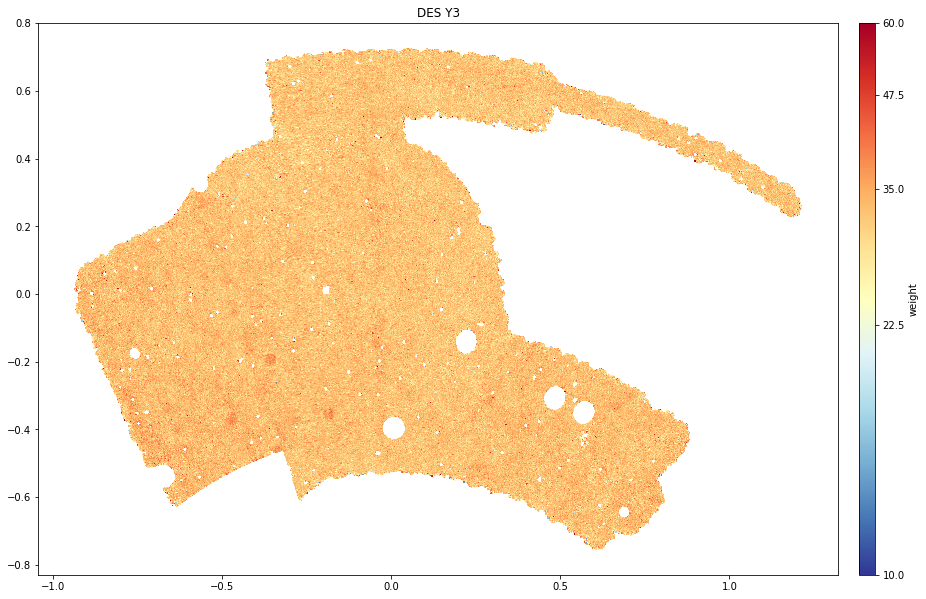

In [56]:
# weight 
w = np.array(master['catalog']['metacal']['unsheared']['weight'])
w = w[select_all]
print(np.mean(w))
print(min(w))
print(max(w))
w_map = np.zeros(hp.nside2npix(nside))
pix1 = convert_to_pix_coord(ra_master[select_all],dec_master[select_all], nside=nside)
unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)
w_map[unique_pix1] += np.bincount(idx_rep1, weights=w)

mas_desy3 = desy3_map!=0.
w_map[mas_desy3] = w_map[mas_desy3]/desy3_map[mas_desy3]
print(np.mean(w_map[mas_desy3]))
log_skm_plot(w_map, ~mas_desy3 , sep=15 , title = 'DES Y3',add_rmp=False, ra = [], dec = [], richness = [], x_size = 15, y_size = 15, cb_label = 'weight', vmin = 10, vmax = 60,small_scale='True')
plt.savefig('weight.pdf')

51.07012953408368
50.35394793231221
[ 5695852  5695853  5695854 ... 12117619 12117620 12117621]
optimizing parameters of Albers to minimize stdDistortion
best objective 0.046034 at Albers(25.31394925294536,-35.86924773198294,-57.27823104418549,-11.346250239135758)
(array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))


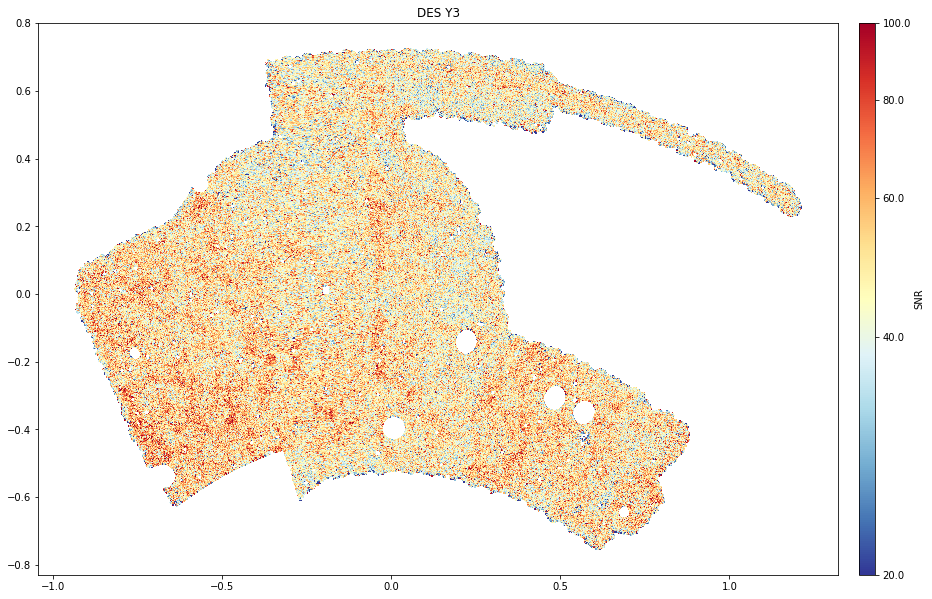

In [43]:
# snr 
snr = snr[select_all]
print(np.mean(snr))
snr_map = np.zeros(hp.nside2npix(nside))
pix1 = convert_to_pix_coord(ra_master[select_all],dec_master[select_all], nside=nside)
unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)
snr_map[unique_pix1] += np.bincount(idx_rep1, weights=snr)

mas_desy3 = desy3_map!=0.
snr_map[mas_desy3] = snr_map[mas_desy3]/desy3_map[mas_desy3]
print(np.mean(snr_map[mas_desy3]))
log_skm_plot(snr_map, ~mas_desy3 , sep=15 , title = 'DES Y3',add_rmp=False, ra = [], dec = [], richness = [], x_size = 15, y_size = 15, cb_label = 'SNR', vmin = 20, vmax = 100,small_scale='True')
plt.savefig('snr.pdf')

1.5754855350285673
0.5000000148764586
5167.646681995015
1.5546737565843225
[ 5695852  5695853  5695854 ... 12117619 12117620 12117621]
optimizing parameters of Albers to minimize stdDistortion
best objective 0.046034 at Albers(25.31394925294536,-35.86924773198294,-57.27823104418549,-11.346250239135758)
(array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))


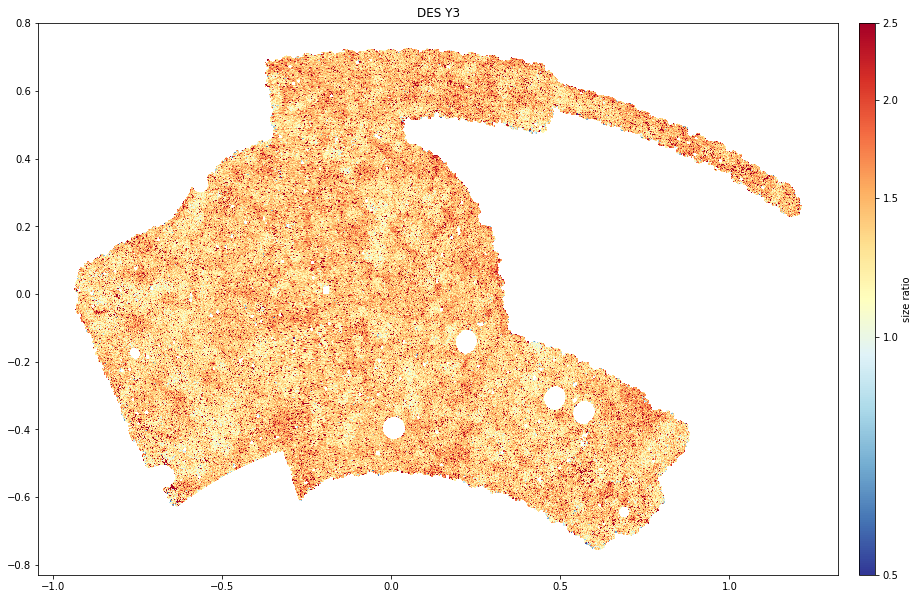

In [44]:
# Size ratio  (now made with psf_T)
SR= np.array(master['catalog']['metacal']['unsheared']['size_ratio'])[select_all]
print(np.mean(SR))  
print(min(SR))
print(max(SR))

SR_map = np.zeros(hp.nside2npix(nside))
pix1 = convert_to_pix_coord(ra_master[select_all],dec_master[select_all], nside=nside)
unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)
SR_map[unique_pix1] += np.bincount(idx_rep1, weights=SR)

mas_desy3 = desy3_map!=0.
SR_map[mas_desy3] = SR_map[mas_desy3]/desy3_map[mas_desy3]
print(np.mean(SR_map[mas_desy3]))
log_skm_plot(SR_map, ~mas_desy3 , sep=15 , title = 'DES Y3',add_rmp=False, ra = [], dec = [], richness = [], x_size = 15, y_size = 15, cb_label = 'size ratio', vmin = 0.5, vmax = 2.5,small_scale='True')
plt.savefig('SR.pdf')

In [46]:
# do same for sig e 

e1 = np.array(master['catalog']['metacal']['unsheared']['e_1'])[select_all]  #/R11_1
e2 = np.array(master['catalog']['metacal']['unsheared']['e_2'])[select_all]  #/R22_1

e=np.sqrt(e1**2+e2**2)

R_ave = 0.5*(R11_1 + R22_1)
print(R_ave)

e1corr= (e1-np.mean(e1))/(R_ave**2)
e2corr= (e2-np.mean(e2))/(R_ave**2)

e1corr2=e1corr**2
e2corr2=e2corr**2

desy3_map = np.zeros(hp.nside2npix(nside))
pix1 = convert_to_pix_coord(ra_master[select_all],dec_master[select_all], nside=nside)
unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)
desy3_map[unique_pix1] += np.bincount(idx_rep1, weights=np.ones(len(pix1)))
mas_desy3 = desy3_map!=0.
res = desy3_map/(hp.pixelfunc.nside2pixarea(nside,degrees=True)*(60*60)) 

desy3_map = np.zeros(hp.nside2npix(nside))
real_e1_map = np.zeros(hp.nside2npix(nside))
real_e_map = np.zeros(hp.nside2npix(nside))
e1_map = np.zeros(hp.nside2npix(nside))
e2_map = np.zeros(hp.nside2npix(nside))
R_map = np.zeros(hp.nside2npix(nside))

pix1 = convert_to_pix_coord(ra_master[select_all],dec_master[select_all], nside=nside)
unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)

desy3_map[unique_pix1] += np.bincount(idx_rep1, weights=np.ones(len(pix1)))
real_e1_map[unique_pix1] += np.bincount(idx_rep1, weights= e1)
real_e_map[unique_pix1] += np.bincount(idx_rep1, weights= e)
e1_map[unique_pix1] += np.bincount(idx_rep1, weights= e1corr2)
e2_map[unique_pix1] += np.bincount(idx_rep1, weights= e2corr2)
R_map[unique_pix1] += np.bincount(idx_rep1, weights= np.ones(len(pix1))*R_ave)


0.37590181583034277


optimizing parameters of Albers to minimize stdDistortion
best objective 0.046034 at Albers(25.31394925294536,-35.86924773198294,-57.27823104418549,-11.346250239135758)


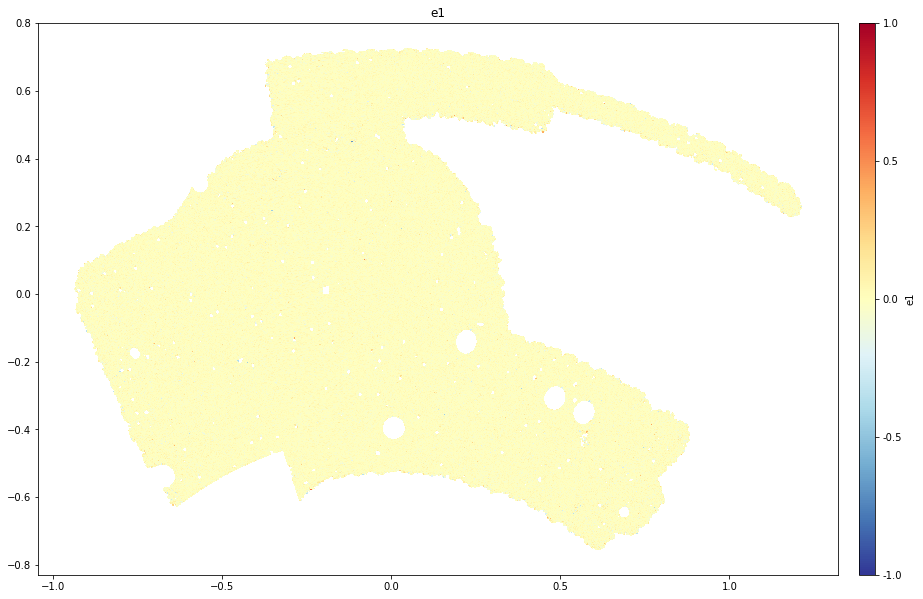

In [47]:
#e1 map 
mas_desy3 = desy3_map!=0.
real_e1_map[mas_desy3] = real_e1_map[mas_desy3]/desy3_map[mas_desy3]
skm_plot(real_e1_map, ~mas_desy3 , sep=15 , title = 'e1',add_rmp=False, ra = [], dec = [], richness = [], x_size = 15, y_size = 15, cb_label = 'e1', vmin = -1, vmax = 1,small_scale='True')


optimizing parameters of Albers to minimize stdDistortion
best objective 0.046034 at Albers(25.31394925294536,-35.86924773198294,-57.27823104418549,-11.346250239135758)


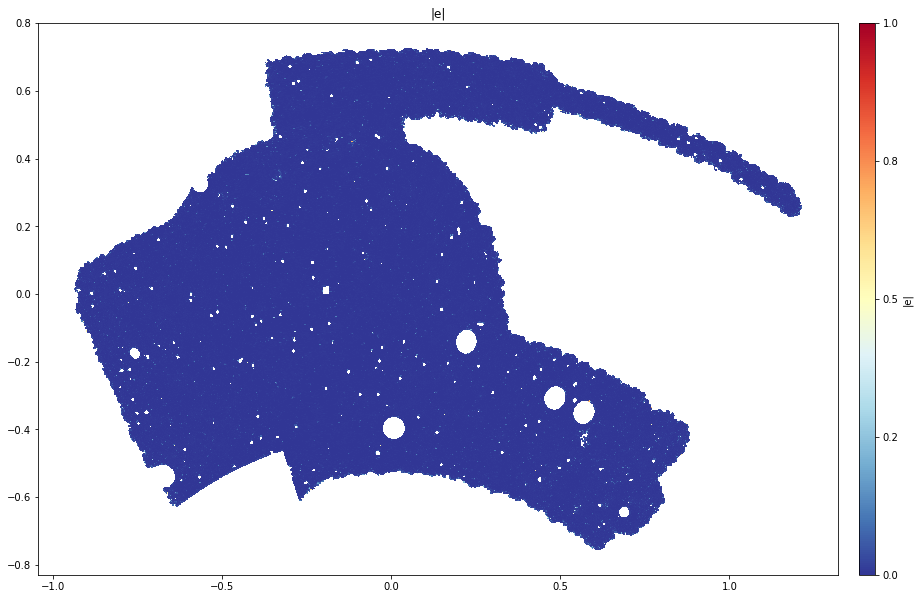

In [54]:
#e map 
mas_desy3 = desy3_map!=0.
real_e_map[mas_desy3] = real_e_map[mas_desy3]/desy3_map[mas_desy3]
skm_plot(real_e_map, ~mas_desy3 , sep=15 , title = '|e|',add_rmp=False, ra = [], dec = [], richness = [], x_size = 15, y_size = 15, cb_label = '|e|', vmin = 0, vmax = 1,small_scale='True')


In [ ]:
#R map 

mas_desy3 = desy3_map!=0.
R_map[mas_desy3] = R_map[mas_desy3]/desy3_map[mas_desy3]
skm_plot(R_map, ~mas_desy3 , sep=15 , title = 'R',add_rmp=False, ra = [], dec = [], richness = [], x_size = 15, y_size = 15, cb_label = 'R', vmin = 0, vmax = 1,small_scale='True')

best objective 0.046034 at Albers(25.31394925294536,-35.86924773198294,-57.27823104418549,-11.346250239135758)


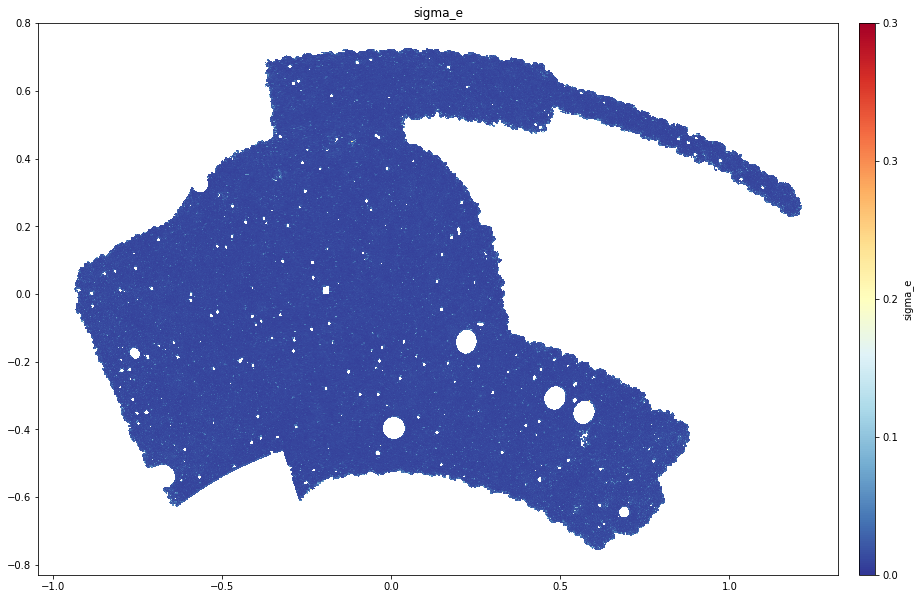

In [50]:
# sig e map   
np.sqrt( (sum_we2_1 / sum_ws**2 + sum_we2_2 / sum_ws**2) * (sum_w**2 / sum_w2) / 2. )
#  sum_w2    = np.sum( w**2  ) --> same as in neff  
# sum_w     = np.sum( w     ) --> same as in neff 
#    sum_we2_1 = np.sum( w**2 * ( e1)**2 )
#   sum_we2_2 = np.sum( w**2 * ( e2 )**2 )
#   sum_ws    = np.sum( w * R )
#    sum_w2s2  =np.sum( w**2 * R**2 )

sige_map=np.sqrt((e1_map+e2_map)*(hp.pixelfunc.nside2pixarea(nside,degrees=True)*0.5))
#sige_map=np.sqrt((e1_map/R_map**2+e2_map/R_map**2)*(hp.pixelfunc.nside2pixarea(nside,degrees=True)*0.5))
mas_desy3 = desy3_map!=0.
sige_map[mas_desy3] = sige_map[mas_desy3]/desy3_map[mas_desy3]
skm_plot(sige_map, ~mas_desy3 , sep=15 , title = 'sigma_e',add_rmp=False, ra = [], dec = [], richness = [], x_size = 15, y_size = 15, cb_label = 'sigma_e', vmin = 0, vmax = 0.35,small_scale='True')


In [51]:
# add Y1 and SV outlines 